In [1]:
import yfinance as yf
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import ta
import talib
from fracdiff.sklearn import Fracdiff
import numpy as np


In [2]:
aapl = yf.download('AAPL', start='2018-01-01', end='2024-01-01')

c:\Conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [3]:
aapl = add_all_ta_features(
    aapl, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

c:\Conda\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [4]:
# Initialize the Fracdiff object
fd = Fracdiff(0.8)

# Apply fractional differencing to the 'Close' price
aapl['Close_fdiff'] = fd.fit_transform(aapl[['Close']].values)

In [5]:
aapl.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       

In [6]:
for indicator in aapl.columns:
    print(indicator, adfuller(aapl[indicator])[1])
    if adfuller(aapl[indicator])[1] < 0.1:
        aapl.drop(columns=indicator)

Open 0.901557554078549
High 0.8810647957472416
Low 0.887003127050867
Close 0.8822398141495197
Adj Close 0.8896865231863318
Volume 8.665487652094114e-05
volume_adi 0.9308194995060273
volume_obv 0.2726040054107609
volume_cmf 7.207910354946902e-06
volume_fi 8.029142687733171e-13
volume_em 2.9069128265647406e-28
volume_sma_em 2.4586008844819504e-11
volume_vpt 0.6182819062353744
volume_vwap 0.8800141320053836
volume_mfi 4.0008060204326935e-10
volume_nvi 0.9497121899735641
volatility_bbm 0.8900706567179949
volatility_bbh 0.8564688652842396
volatility_bbl 0.929455163422092
volatility_bbw 1.1904026049225717e-05
volatility_bbp 3.2700578921042417e-16
volatility_bbhi 0.0
volatility_bbli 5.4121157769203655e-24
volatility_kcc 0.8669328555186192
volatility_kch 0.875136214140098
volatility_kcl 0.8758248125671266
volatility_kcw 0.0010538640034443382
volatility_kcp 5.287555415873231e-15
volatility_kchi 1.707193818269719e-27
volatility_kcli 1.480882943663117e-20
volatility_dcl 0.9018573662218577
volatil

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(aapl)

In [8]:
price_diff = np.diff(aapl['Close'].values)
# Label is 1 if the difference is positive, and 0 otherwise
labels = (price_diff > 0).astype(int)

In [9]:
aapl['diff'] = aapl['Close'].diff()
aapl['label'] = np.where(aapl['diff'] > 0, 1, 0)
aapl = aapl.dropna()

In [10]:
label = aapl['label'].tolist()

In [11]:
# Determine the split point
split_point = int(len(data_scaled) * 0.95)  # 80% for training, 20% for testing

# Split the data_scaled
train_data = data_scaled[:split_point]
test_data = data_scaled[split_point-59:]

# The labels should also be split accordingly
train_labels = labels[:split_point]
test_labels = labels[split_point-59:]

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Assuming you want to predict based on the past 60 days of data
SEQ_LEN = 60
X = []
y = []

for i in range(SEQ_LEN, len(train_data)):
    X.append(train_data[i-SEQ_LEN:i])  # 60 days of features
    y.append(train_labels[i-1])  # Corresponding label

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create the dataset
dataset = StockDataset(X_tensor, y_tensor)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [13]:
SEQ_LEN = 60
X = []
y = []

for i in range(SEQ_LEN, len(test_data)):
    X.append(test_data[i-SEQ_LEN:i])  # 60 days of features
    y.append(test_labels[i-1])  # Corresponding label

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create the dataset
dataset = StockDataset(X_tensor, y_tensor)

# Create the DataLoader
testloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [14]:
import torch.nn as nn

class StockPredictor(nn.Module):
    def __init__(self, num_features, hidden_units, num_layers):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(num_features, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return torch.sigmoid(out)

# Define the model
num_features = X.shape[-1]  # Number of features
hidden_units = 100  # Number of hidden units
num_layers = 2  # Number of LSTM layers



In [15]:
model = StockPredictor(num_features, hidden_units, num_layers)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

minLossModel = StockPredictor(num_features, hidden_units, num_layers)
# Training loop
num_epochs = 100
min_loss = 1
epochLoss = []
for epoch in range(num_epochs):
    for features, labels in dataloader:
        # Forward pass
        predictions = model(features).squeeze()
        loss = criterion(predictions, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epochLoss.append(loss.item())
    if loss.item() < min_loss:
        min_loss = loss.item()
        minLossModel = model

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'stock_predictor.pth')

Epoch [10/100], Loss: 0.6685, minimum Loss: 0.6685
Epoch [20/100], Loss: 0.6099, minimum Loss: 0.6099
Epoch [30/100], Loss: 0.6418, minimum Loss: 0.5597
Epoch [40/100], Loss: 0.8104, minimum Loss: 0.4366
Epoch [50/100], Loss: 0.3784, minimum Loss: 0.3344
Epoch [60/100], Loss: 0.2472, minimum Loss: 0.2472
Epoch [70/100], Loss: 0.1748, minimum Loss: 0.1748
Epoch [80/100], Loss: 0.0556, minimum Loss: 0.0556
Epoch [90/100], Loss: 0.0340, minimum Loss: 0.0340
Epoch [100/100], Loss: 0.0297, minimum Loss: 0.0180


In [16]:
"""num_epochs = 100
for epoch in range(num_epochs):
    for features, labels in dataloader:
        # Forward pass
        predictions = model(features).squeeze()
        loss = criterion(predictions, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epochLoss.append(loss.item())
    if loss.item() < min_loss:
        min_loss = loss.item()
        minLossModel = model

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'stock_predictor.pth')"""

"num_epochs = 100\nfor epoch in range(num_epochs):\n    for features, labels in dataloader:\n        # Forward pass\n        predictions = model(features).squeeze()\n        loss = criterion(predictions, labels)\n\n        # Backward pass and optimization\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    epochLoss.append(loss.item())\n    if loss.item() < min_loss:\n        min_loss = loss.item()\n        minLossModel = model\n\n    if (epoch+1) % 10 == 0:\n        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, minimum Loss: {min_loss:.4f}')\n\n# Save the model\ntorch.save(model.state_dict(), 'stock_predictor.pth')"

In [17]:
# Make sure to call minLossModel.eval() when evaluating/predicting to set dropout and batch normalization layers to evaluation mode

minLossModel.eval()

# List to hold predictions
predictions = []

# No need to track gradients when predicting
with torch.no_grad():
    for features, labels in testloader:
        # Forward pass
        output = minLossModel(features).squeeze()
        predictions.append(output.cpu().numpy())

# Concatenate all batches
predictions = np.concatenate(predictions, axis=0)

print(predictions, test_labels[59:])
predictlabels = (predictions > 0.5).astype(int)
accurate = (predictlabels == test_labels[59:]).astype(int)
print(sum(accurate) / len(accurate),sum(accurate[:20]) / len(accurate[:20]))

[1.9752361e-02 1.1207566e-01 8.6758703e-01 9.8555887e-01 3.3635384e-01
 2.8817246e-02 6.2560281e-03 1.4296542e-02 3.8829374e-01 6.3555436e-03
 9.7260642e-01 9.9919719e-01 9.7899729e-01 6.6513044e-01 1.5410234e-01
 8.9033699e-01 9.9255824e-01 1.2024231e-01 8.8816571e-01 9.9987733e-01
 9.9990880e-01 9.9540186e-01 9.6361059e-01 9.9703646e-01 9.2931718e-01
 2.2351658e-02 6.0786260e-03 2.1251118e-01 7.6998150e-01 2.7161602e-02
 9.9987292e-01 2.5170691e-02 4.9407766e-03 5.1414244e-02 9.9952829e-01
 7.4797840e-04 1.1680062e-03 1.0983329e-01 2.7643022e-01 9.9904734e-01
 9.9993169e-01 9.9998963e-01 9.7142786e-01 2.6544442e-03 4.8257424e-03
 8.4175414e-01 8.7115920e-01 8.3174100e-03 3.7593173e-03 6.1667062e-02
 9.4911277e-01 1.8495278e-01 1.3880853e-01 7.3603404e-01 9.8863119e-01
 9.8673439e-01 8.2128495e-01 6.5613425e-01 7.9247200e-01 9.8299533e-01
 3.2356545e-01 6.7330974e-01 9.9107516e-01 1.5946664e-01 4.1376787e-01
 8.1514399e-03 8.3817971e-01 3.3799362e-01 9.1810942e-01 5.0365669e-01
 6.903

In [18]:
count = 0
total = 0
for i in range(20):
    if predictions[i] < 0.1:
        count +=1
        if test_labels[59+i] == 0:
            total += 1
    elif predictions[i] > 0.9:
        count+=1
        if test_labels[59+i] == 1:
            total+=1

total / count



0.7272727272727273

In [19]:
count

11

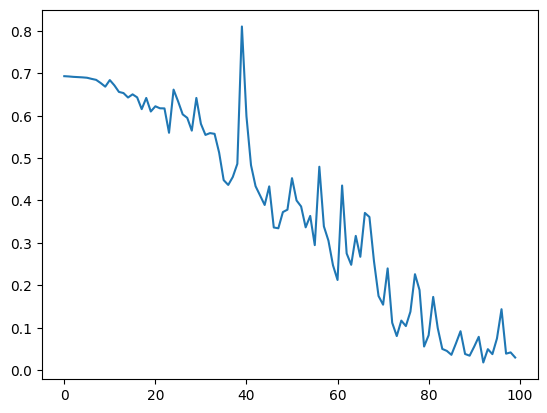

In [20]:
plt.plot(epochLoss)